In [1]:
# load the required packages
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

## Garnet MDP Problem

It is a simple simulation on Markov Decision Process. <br/>
MDP = (S, A, P, R, γ)

In [2]:
class MDP:
    def __init__(self, Ns, Na, Nb, dF):
        self.Ns = Ns
        self.Na = Na
        self.Nb = Nb
        self.dF = dF
        
        # transition probability function P
        self.P = np.ndarray((Ns, Na, Ns), float)
        for i in range(Ns):
            for j in range(Na):
                sampleArr = rnd.sample(range(Ns), k = Nb)
                P_sum = np.random.rand(Nb - 1)
                P_sum = np.concatenate((P_sum, np.array([0, 1])), axis = 0)
                P_sum = np.sort(P_sum)
                for k in range(Nb):
                    self.P[i][j][sampleArr[k]] = P_sum[k + 1] - P_sum[k]
                for k in range(Ns):
                    if k not in sampleArr:
                        self.P[i][j][k] = 0

        # reward function R
        self.R = np.random.uniform(size = (self.Ns, self.Na))
    
    # policy function pi
    def pi(self, s):
        return rnd.randrange(self.Na)
    
    def getValue(self):
        
        P_pi = np.sum(self.P * 1 / self.Na, axis=1)
        R_pi = np.sum(self.R * 1 / self.Na, axis=1)
        
        return np.linalg.inv(np.identity(self.Ns) - self.dF * P_pi).dot(R_pi)

In [3]:
def MSE(V, V_true):
    if len(V) != len(V_true):
        return -1.0
    else:
        error = 0
        for i in range(len(V)):
            error += (V[i]-V_true[i]) ** 2
        return error / len(V)

In [4]:
def td(m1, T, d):
    
#     print("T: "+ str(T) + ", d: "+ str(d))
    S = np.ndarray((T+1), int)
    A = np.ndarray((T), int)
    S[0] = 0
    
    # T: sequence length
    # V_td: value function computed by TD method
    # V_lfa: value function computed by TD method with LFA
    # d: dimension of feature vector for LFA
    V_td = np.zeros((m1.Ns), float)
    V_lfa = np.zeros((m1.Ns), float)
    
    phi = np.ndarray((m1.Ns, d), float)
    for i in range(m1.Ns):
        for j in range(d):
            phi[i][j] = rnd.random()
    theta = np.zeros((d), float)

    # simulation of MDP
    for t in range(T):
        
        # alpha: learning rate for TD method
        # diminishing step size
        alpha_td = 5 / (t + 50)
        alpha_lfa = 0.1 / (t + 1)
        
        # eps: for regularization
        eps = 1e-4
        
        A[t] = m1.pi(S[t])
        S[t+1] = np.random.choice(m1.Ns, 1, p = m1.P[S[t]][A[t]])
        r = m1.R[S[t]][A[t]]
        V_td[S[t]] = V_td[S[t]] + alpha_td * (r + m1.dF * V_td[S[t+1]] - V_td[S[t]])
        theta = theta + alpha_lfa * (r + m1.dF * phi[S[t+1]].transpose() * theta
                                     - phi[S[t]].transpose() * theta) * phi[S[t]] - alpha_lfa * eps * theta
    
    for i in range(m1.Ns):
        V_lfa[i] = phi[i].transpose().dot(theta)
    
    # print out the result
    V_true = m1.getValue()
#     print("V_td: " + str(V_td))
#     print("MSE of V_td: " + str(MSE(V_td, V_true)))
#     print("V_lfa: " + str(V_lfa))
#     print("MSE of V_lfa: " + str(MSE(V_lfa, V_true)))
    return MSE(V_td, V_true), MSE(V_lfa, V_true)

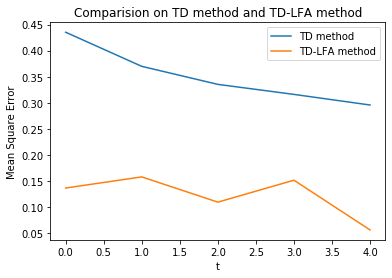

In [5]:
m1 = MDP(10, 5, 2, 0.7)
MSE_td = np.ndarray((5), float)
MSE_lfa = np.ndarray((5), float)
for i in range(5):
    MSE_td[i], MSE_lfa[i] = td(m1, (i+1) * 50000, 10)
plt.plot(range(5), MSE_td, label="TD method")
plt.plot(range(5), MSE_lfa, label="TD-LFA method")
plt.legend()
plt.title("Comparision on TD method and TD-LFA method")
plt.ylabel("Mean Square Error")
plt.xlabel("t")
plt.show() 